In [1]:
#import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, Input, concatenate,Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
import time

C:\Users\lenovo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#class inputs
base_path = r"C:\Users\lenovo\\DualChannelThesis\CWRU"

statistics_directories = [
    base_path + "\\stats\\bopolar7",
    base_path + "\\stats\\bopolar14",
    base_path + "\\stats\\bopolar21",
    base_path + "\\stats\\irpolar7",
    base_path + "\\stats\\irpolar14",
    base_path + "\\stats\\irpolar21",
    base_path + "\\stats\\orpolar7",
    base_path + "\\stats\\orpolar14",
    base_path + "\\stats\\orpolar21",
]

image_directories = [
    base_path + "\\spectogtam\\bopolar7",
    base_path + "\\spectogtam\\bopolar14",
    base_path + "\\spectogtam\\bopolar21",
    base_path + "\\spectogtam\\irpolar7",
    base_path + "\\spectogtam\\irpolar14",
    base_path + "\\spectogtam\\irpolar21",
    base_path + "\\spectogtam\\orpolar7",
    base_path + "\\spectogtam\\orpolar14",
    base_path + "\\spectogtam\\orpolar21",
]


In [3]:
def get_label(directory):
    if "bopolar" in directory:
        return 0  # bopolar
    elif "irpolar" in directory:
        return 1  # irpolar
    else:
        return 2  # orpolar


In [4]:
statistics_data = []
statistics_labels = []
for directory in statistics_directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            if not df.empty:
                features = df.values.flatten()
                statistics_data.append(features)
                statistics_labels.append(get_label(directory))

In [5]:
polar_images = []
polar_labels = []
for directory in image_directories:
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.png'):
            file_path = os.path.join(directory, file)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))
            polar_images.append(img)
            polar_labels.append(get_label(directory))

In [6]:
polar_images = np.array(polar_images)
polar_labels = np.array(polar_labels)

statistics_data = np.array(statistics_data)
statistics_labels = np.array(statistics_labels)

In [7]:
#splitting
statistics_X_train, statistics_X_test, statistics_y_train, statistics_y_test = train_test_split(
    statistics_data, statistics_labels, test_size=0.2, random_state=42)

In [8]:
#scaling the numeric statistical input
scaler = StandardScaler()
statistics_X_train = scaler.fit_transform(statistics_X_train)
statistics_X_test = scaler.transform(statistics_X_test)

In [9]:
#splitting
polar_X_train, polar_X_test, polar_y_train, polar_y_test = train_test_split(
    polar_images, polar_labels, test_size=0.2, random_state=42)

In [10]:
#Generating class weight
class_counts = Counter(statistics_labels)
total_samples = len(statistics_labels)
class_weights = {class_index: total_samples / (class_count * len(class_counts)) for class_index, class_count in class_counts.items()}


In [11]:
#generate data as a data augmentation step

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(polar_X_train)

In [12]:
#define inputs
statistics_input = Input(shape=(statistics_X_train.shape[1],1))
polar_input = Input(shape=(64, 64, 3))

In [13]:
#define statistic based 1D CNN model
def statistics_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape, padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 2, activation='relu', padding="same"))  # Changed kernel size to 2
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model


In [14]:
def LeNet(input_shape):
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding="same", input_shape=input_shape, activation="relu"))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding="valid", activation="relu"))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation="relu"))
    model.add(Dense(84, activation="relu"))
    return model

In [15]:
polar_base_model = LeNet(input_shape=(64, 64, 3))
polar_output = polar_base_model(polar_input)

statistics_branch_model = statistics_model((statistics_X_train.shape[1], 1))
statistics_output = statistics_branch_model(statistics_input)

In [16]:
#concatanating the features from both channels

combined_input = concatenate([statistics_output, polar_output])
x = Dense(256, activation='relu')(combined_input)
x = Dropout(0.5)(x)
output = Dense((3), activation='softmax')(x)

In [17]:
model = Model(inputs=[statistics_input, polar_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
#model training
epochs_list = [20,30]
batch_sizes_list = [32,64]
results = []
best_accuracy = 0.0  # Initialize best_accuracy
best_time = 0.0
for epoch in epochs_list:
    for batch_size in batch_sizes_list:
        print(f"Training with {epoch} epochs and batch size {batch_size}")
        start_time = time.time()
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit([statistics_X_train, polar_X_train],
                            polar_y_train,
                            epochs=epoch,
                            batch_size=batch_size,
                            validation_split=0.2,
                            class_weight=class_weights)
        end_time = time.time()
        elapsed_time = end_time - start_time
        # Evaluation
        test_loss, test_accuracy = model.evaluate([statistics_X_test, polar_X_test], polar_y_test)
        predictions = model.predict([statistics_X_test, polar_X_test])
        predicted_labels = np.argmax(predictions, axis=1)

        accuracy = accuracy_score(statistics_y_test, predicted_labels)
        f1 = f1_score(statistics_y_test, predicted_labels, average='weighted')
        precision_vals = precision_score(statistics_y_test, predicted_labels, average=None)
        recall_vals = recall_score(statistics_y_test, predicted_labels, average=None)

        n_classes = 3  # Number of classes
        fpr = dict()
        tpr = dict()
        roc_auc_vals = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(statistics_y_test, predictions[:, i], pos_label=i)
            roc_auc_vals[i] = auc(fpr[i], tpr[i])

        results.append({
            'epochs': epoch,
            'batch_size': batch_size,
            'test_accuracy': test_accuracy,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision_vals,
            'recall': recall_vals,
            'roc_auc': roc_auc_vals
        })
        test_loss, test_accuracy = model.evaluate([statistics_X_test, polar_X_test], polar_y_test)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_time = elapsed_time


Training with 20 epochs and batch size 32
Epoch 1/20
36/36 [==============================] - 3s 37ms/step - loss: 3.3633 - accuracy: 0.5195 - val_loss: 0.6618 - val_accuracy: 0.8057
Epoch 2/20
36/36 [==============================] - 1s 29ms/step - loss: 0.3423 - accuracy: 0.8867 - val_loss: 0.2570 - val_accuracy: 0.8622
Epoch 3/20
36/36 [==============================] - 1s 30ms/step - loss: 0.1554 - accuracy: 0.9469 - val_loss: 0.1963 - val_accuracy: 0.9258
Epoch 4/20
36/36 [==============================] - 1s 29ms/step - loss: 0.1424 - accuracy: 0.9496 - val_loss: 0.0701 - val_accuracy: 0.9753
Epoch 5/20
36/36 [==============================] - 1s 29ms/step - loss: 0.0722 - accuracy: 0.9717 - val_loss: 0.1184 - val_accuracy: 0.9611
Epoch 6/20
36/36 [==============================] - 1s 29ms/step - loss: 0.0505 - accuracy: 0.9850 - val_loss: 0.0760 - val_accuracy: 0.9788
Epoch 7/20
36/36 [==============================] - 1s 29ms/step - loss: 0.0296 - accuracy: 0.9912 - val_loss: 0

36/36 [==============================] - 1s 30ms/step - loss: 0.0174 - accuracy: 0.9912 - val_loss: 0.1508 - val_accuracy: 0.9611
Epoch 15/30
36/36 [==============================] - 1s 31ms/step - loss: 0.2157 - accuracy: 0.9124 - val_loss: 0.2865 - val_accuracy: 0.8587
Epoch 16/30
36/36 [==============================] - 1s 31ms/step - loss: 0.1971 - accuracy: 0.8973 - val_loss: 0.2509 - val_accuracy: 0.8940
Epoch 17/30
36/36 [==============================] - 1s 31ms/step - loss: 0.1881 - accuracy: 0.9062 - val_loss: 0.4058 - val_accuracy: 0.8516
Epoch 18/30
36/36 [==============================] - 1s 31ms/step - loss: 0.1880 - accuracy: 0.9009 - val_loss: 0.2606 - val_accuracy: 0.8551
Epoch 19/30
36/36 [==============================] - 1s 30ms/step - loss: 0.1285 - accuracy: 0.9336 - val_loss: 0.1837 - val_accuracy: 0.9470
Epoch 20/30
36/36 [==============================] - 1s 30ms/step - loss: 0.1023 - accuracy: 0.9575 - val_loss: 0.2489 - val_accuracy: 0.9081
Epoch 21/30
36/36 

In [19]:
# print Validation, Accuracy, F1-Score
for result in results:
    print(f"Epochs: {result['epochs']}, Batch Size: {result['batch_size']}, Test Accuracy: {result['test_accuracy']}, F1-Score: {result['f1_score']}")
print(f"Time taken for best hyperparameters (with test accuracy {best_accuracy:.2f}): {best_time:.2f} seconds")


Epochs: 20, Batch Size: 32, Test Accuracy: 0.994350254535675, F1-Score: 0.9943403393447995
Epochs: 20, Batch Size: 64, Test Accuracy: 0.9971751570701599, F1-Score: 0.9971752768556863
Epochs: 30, Batch Size: 32, Test Accuracy: 0.9604519605636597, F1-Score: 0.9604139894183569
Epochs: 30, Batch Size: 64, Test Accuracy: 0.9774011373519897, F1-Score: 0.9773901446892646
Time taken for best hyperparameters (with test accuracy 1.00): 19.50 seconds


In [20]:
#best results
best_result_test = max(results, key=lambda x: x['test_accuracy'])
print("\nBest Hyperparameters (Test Accuracy):")
print("Epochs:", best_result_test['epochs'])
print("Batch Size:", best_result_test['batch_size'])
print("Test Accuracy:", best_result_test['test_accuracy'])


Best Hyperparameters (Test Accuracy):
Epochs: 20
Batch Size: 64
Test Accuracy: 0.9971751570701599


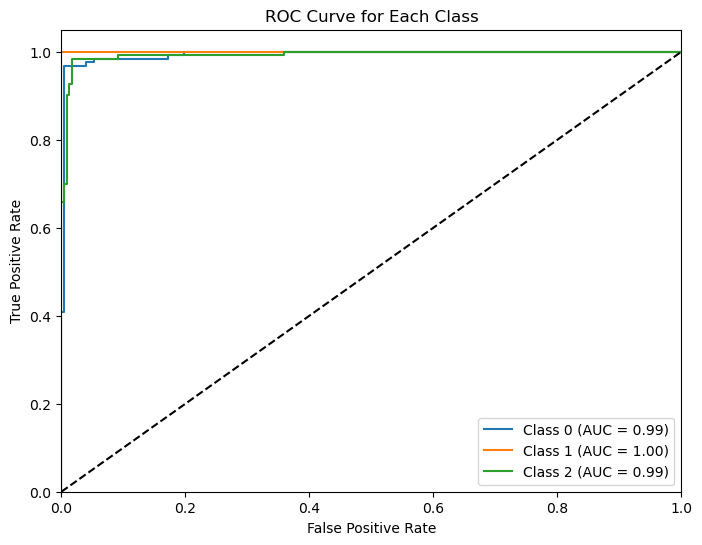

In [21]:
#plot roc curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3  # Number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(polar_y_test, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [22]:
precision = precision_score(polar_y_test, predicted_labels, average=None)
recall = recall_score(polar_y_test, predicted_labels, average=None)

print("\nPrecision for Each Class:", precision)
print("Recall for Each Class:", recall)



Precision for Each Class: [0.99180328 0.99047619 0.95275591]
Recall for Each Class: [0.95275591 1.         0.98373984]


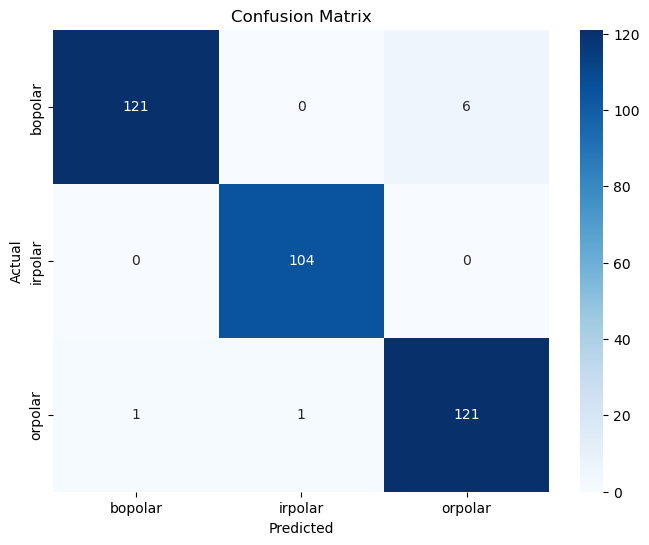

In [23]:
#plot conf_matrix
conf_matrix = confusion_matrix(polar_y_test, predicted_labels)
class_labels = ['bopolar', 'irpolar', 'orpolar']
confusion_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
